# EE596 - Homework 2 Report
##### Color Clustering and Skin Finding
###### Prepared by Paul Adams

## Introduction

I found the `opencv` API more suited for `c++` than `python` and made the design decision to switch to the recommended machine learning library of the `SciPy` stack which is `sci-kit-learn` or by it's import name, `sklearn`. As opposed to `cv2`, `sklearn` has a pythonic interface. All classifiers are trained with the method `fit` and utilized with the method `predict`. Additionally, the documentation is more modern and thorough. As enumerated in the Imports cell below, the modules I used from `sklearn` were `GaussianNB` for a Naive-Bayes implementation, `RandomForestClassifier` for random forests, `gaussian_filter` and `median_filter` for image filtering, `KMeans` for clustering, and `jaccard_similarity_score` to assess performance per assignments guidelines. An additional benefit of `sklearn` is support for parallelization. By using the keyword argument `n_jobs=4`, the KMeans clustering was implemented in parallel for reduced run time.  

To ensure the clusters were well-defined, I set the Kmeans convergence tolerance low, `0.001`. I used median filtering on the images to reduce the amount of local color variation. 

In my initial testing, I found that results were highly sensitive to overlap % threshold and number of clusters so I wrote a wrapper function called `paramterator`. This enabled iterating over a parameter space of classifiers x features x thresholds x K clusters. A model was trained for each set of parameters and then tested against the testing images. The results of each iteration were obtained using Jaccard's index and then cached to a file. This enabled writing an evaluation script that found the best set of parameters for each image and used those for the final results. 

I chose to use several sets of features. Per the assigment, I used `RGB` and `r,g`, in addition I used the combination `RGBrg`. I also coded an implementation of *Log Opponent* space as described in the Forsyth et al. paper **Finding Naked People**. Finally, I used a combination of all features. 

In addition, I iterated over values of overlap threshold ranging from 40 to 70% and from K-means clusters of 4 to 8. The final program takes 2.5 hours to span the 300 combinations at an average of 30 sec. per parameter combination set. Results are discussed below.  

##### Post Results Update:
As discussed below in the results section, the above described strategy suffered from implementation challenges and the parameter space swept was much smaller. A constant `K = 8` was chosen for cluster centers and a constant overlap threshold of 50% was used. 

## Skin Finding Results

#### Note: in the images below, "RF" denotes Random Forest classification and "NB" denotes Naive Bayes classification.

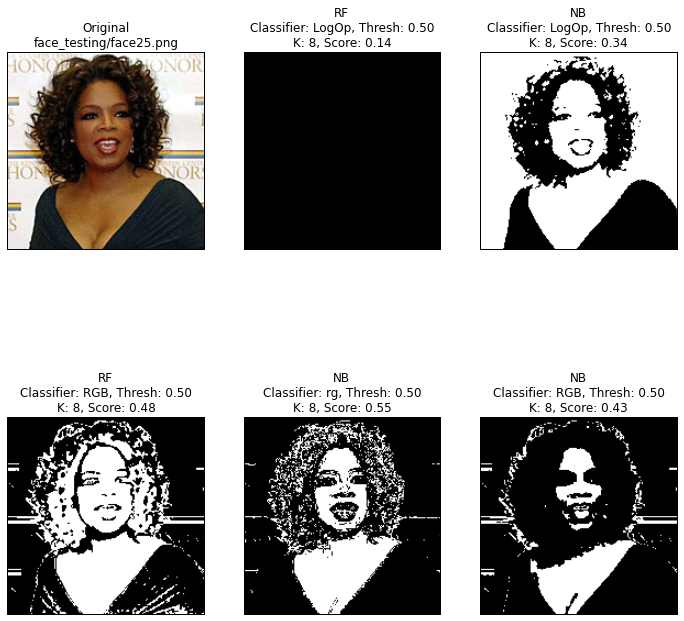

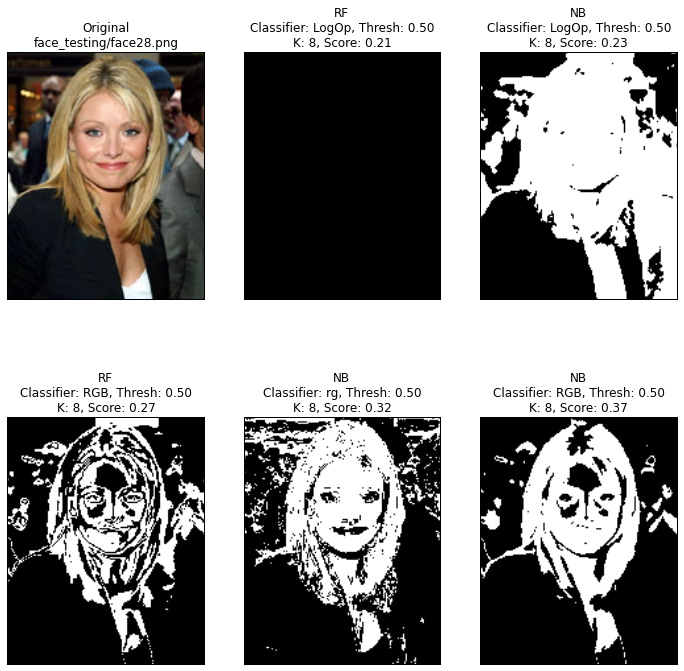

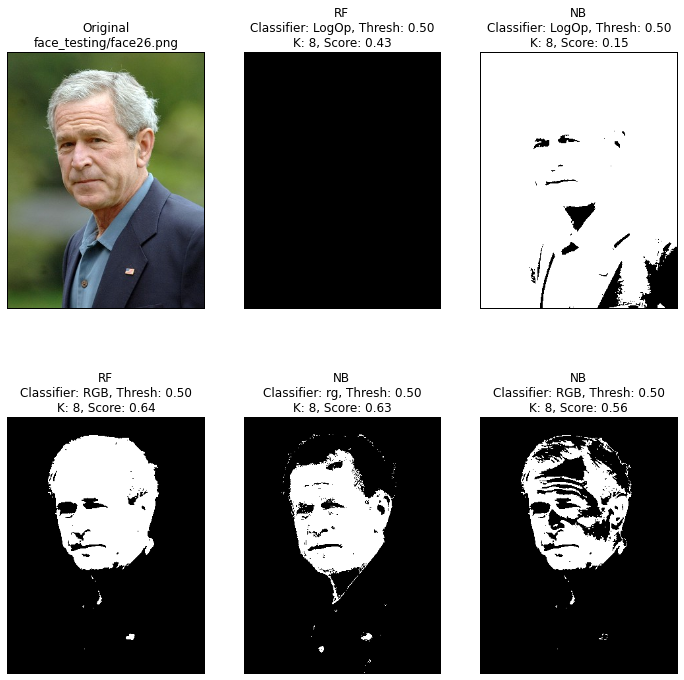

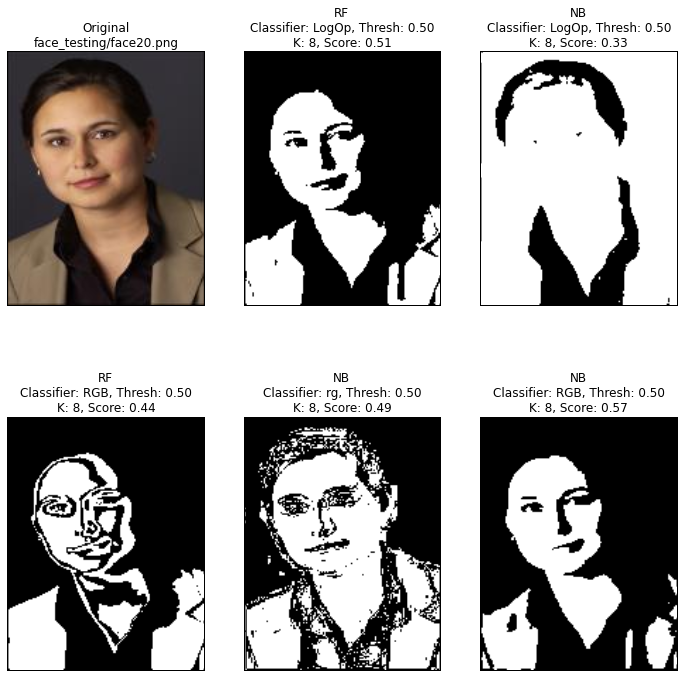

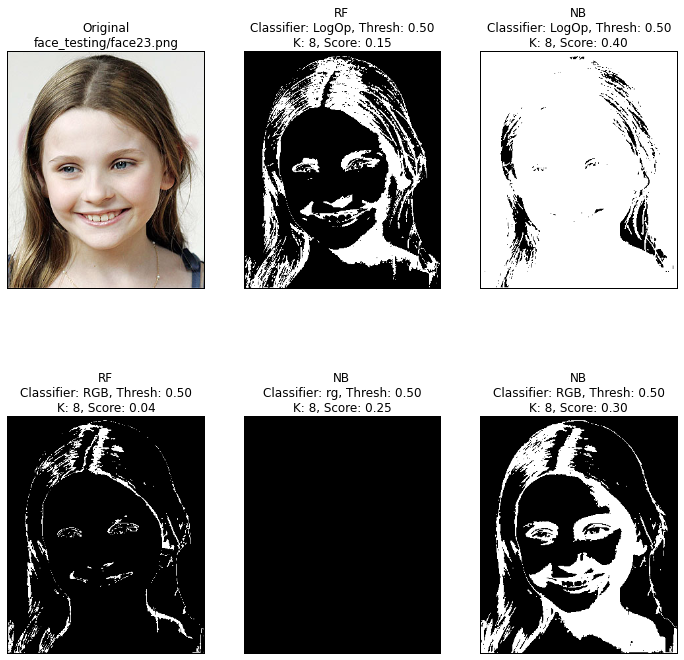

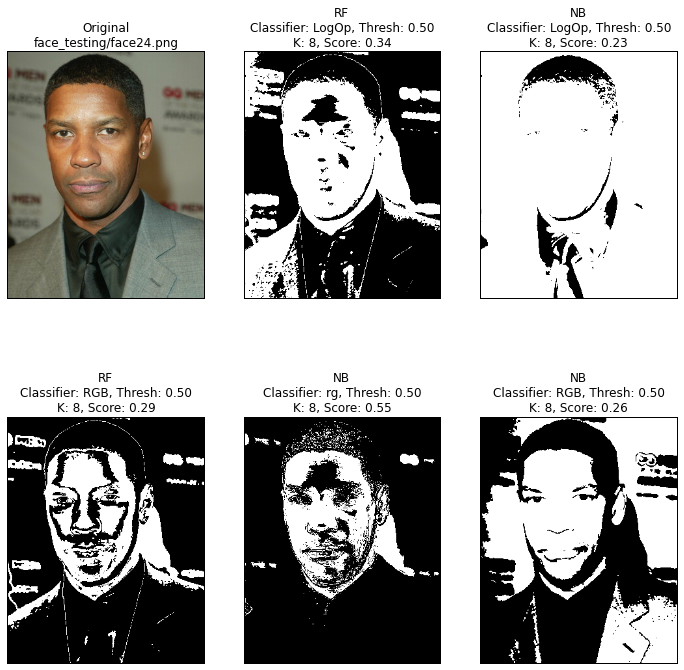

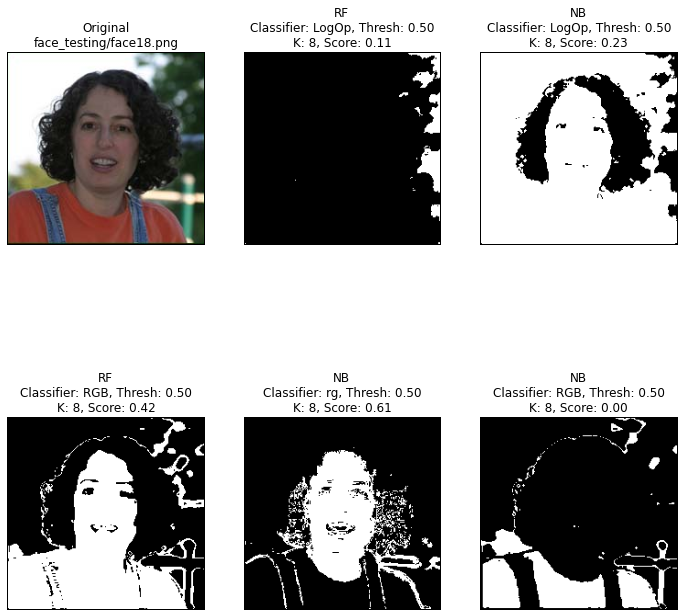

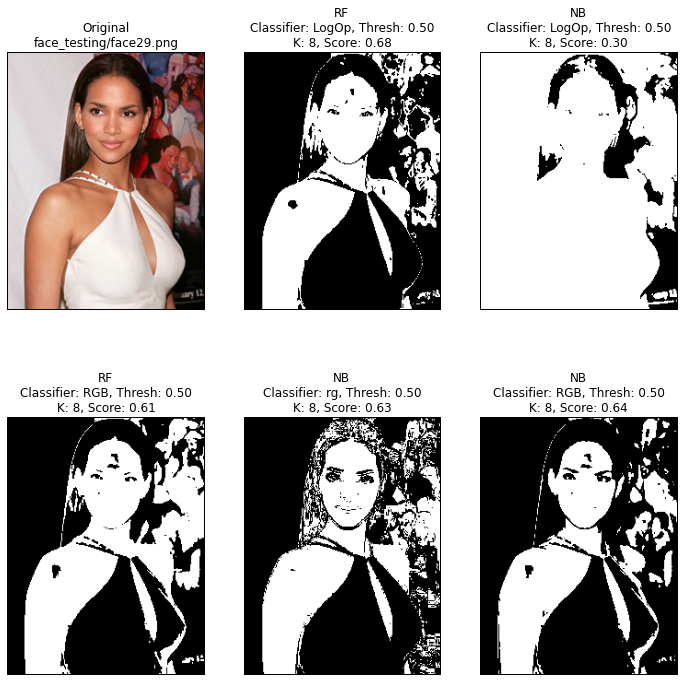

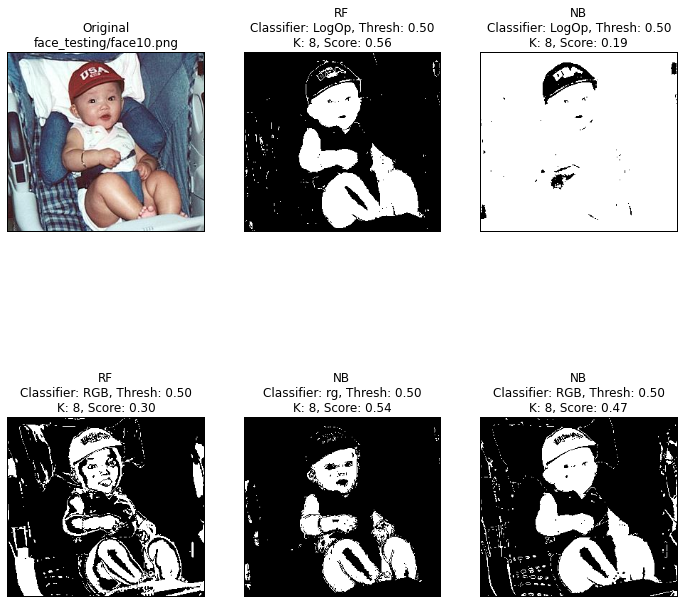

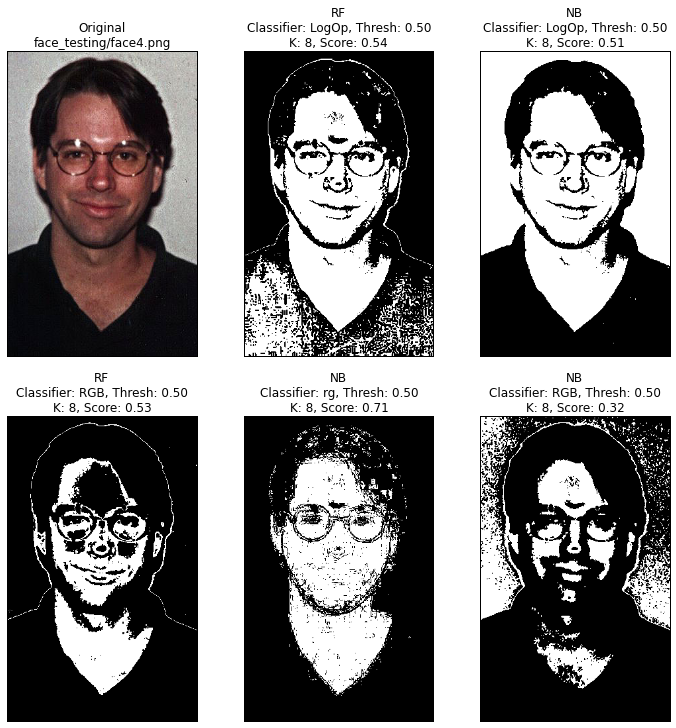

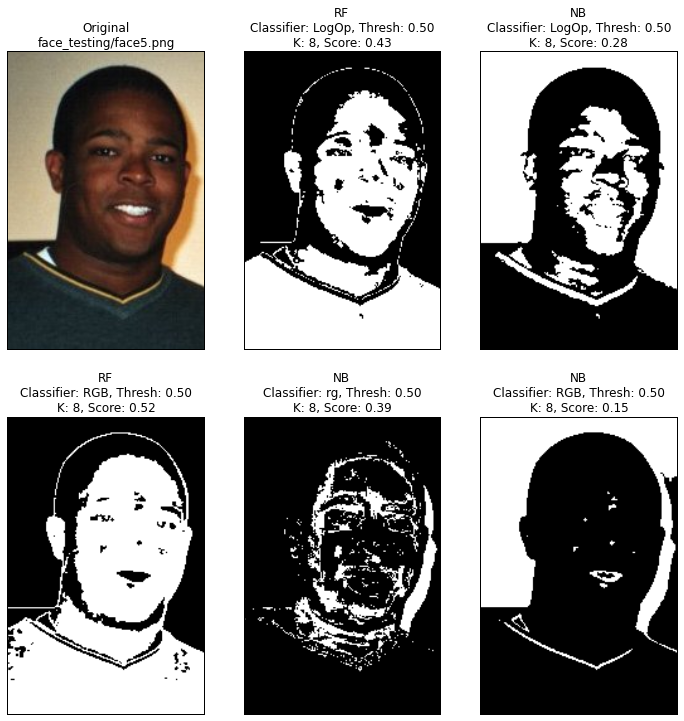

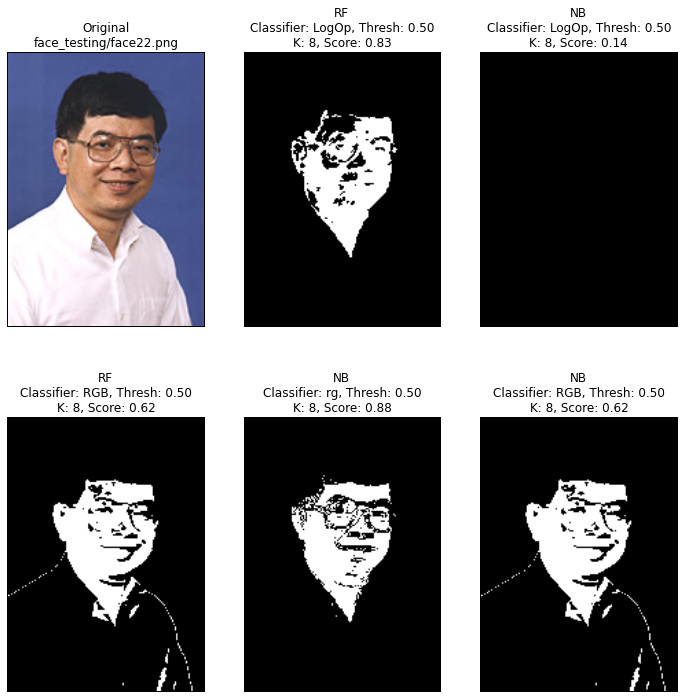

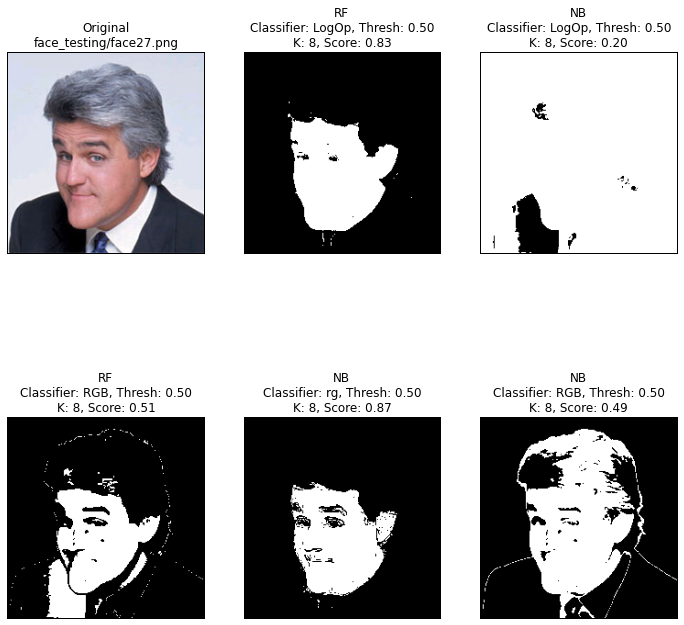

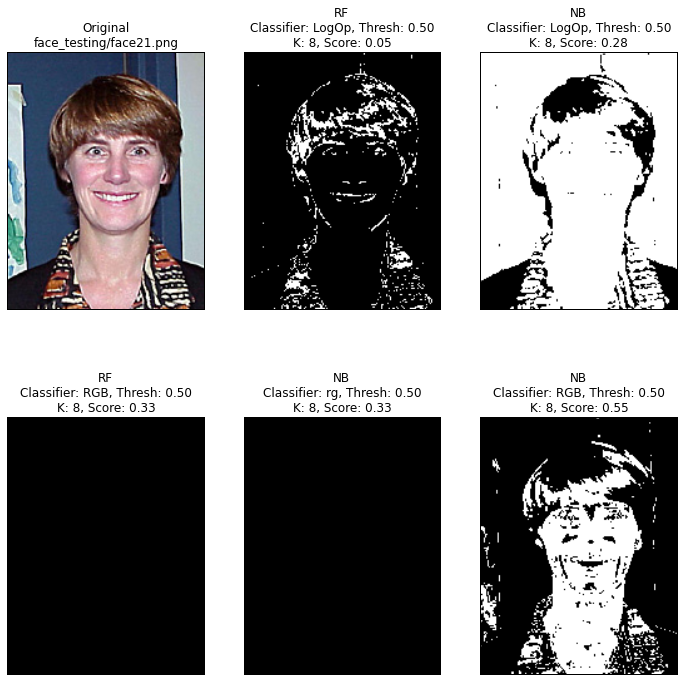

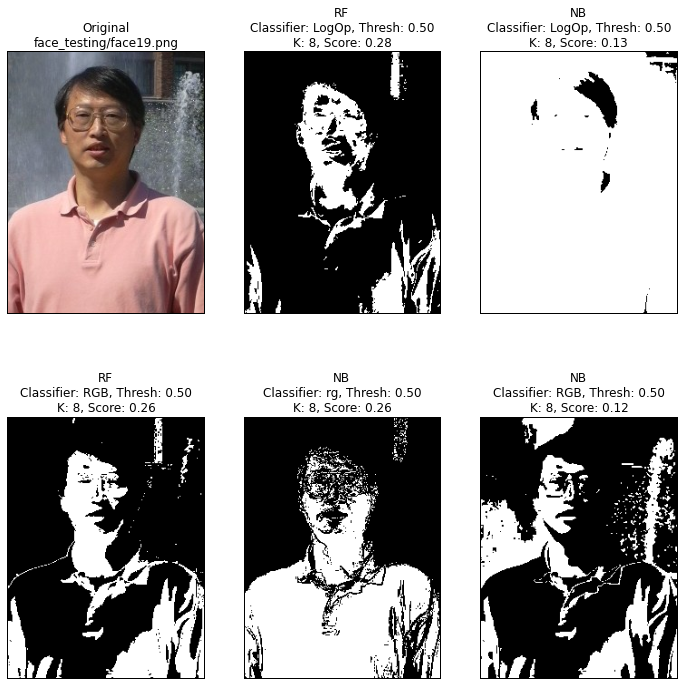

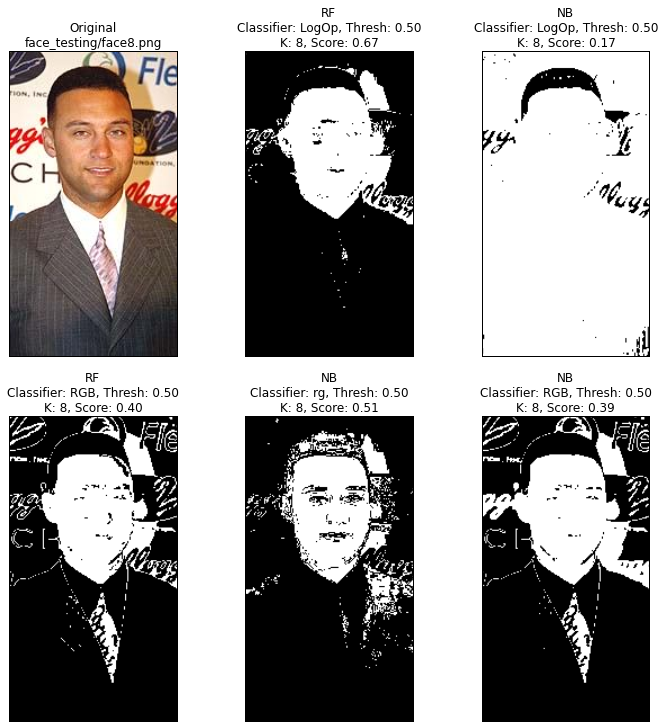

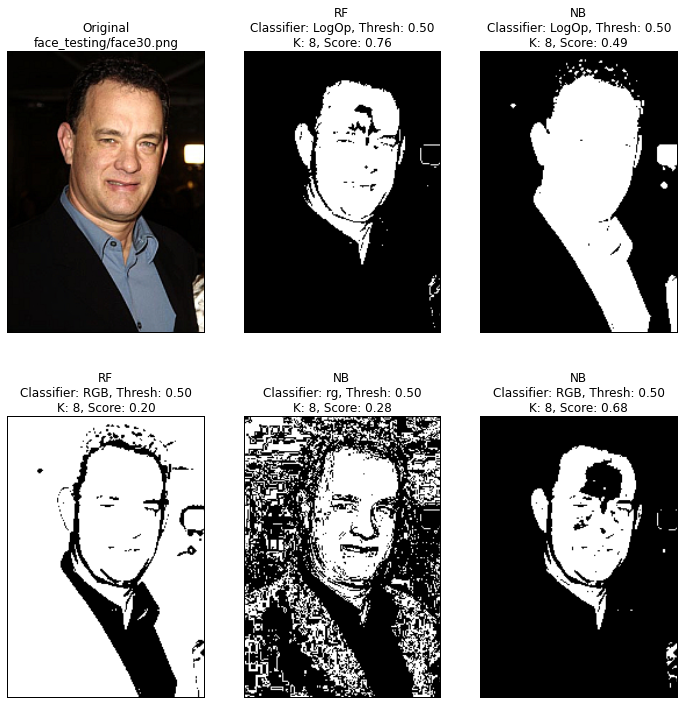

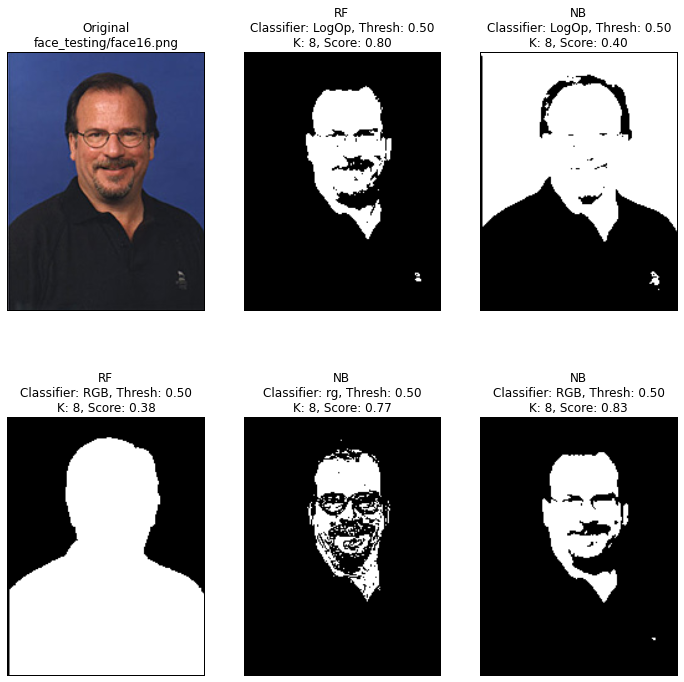

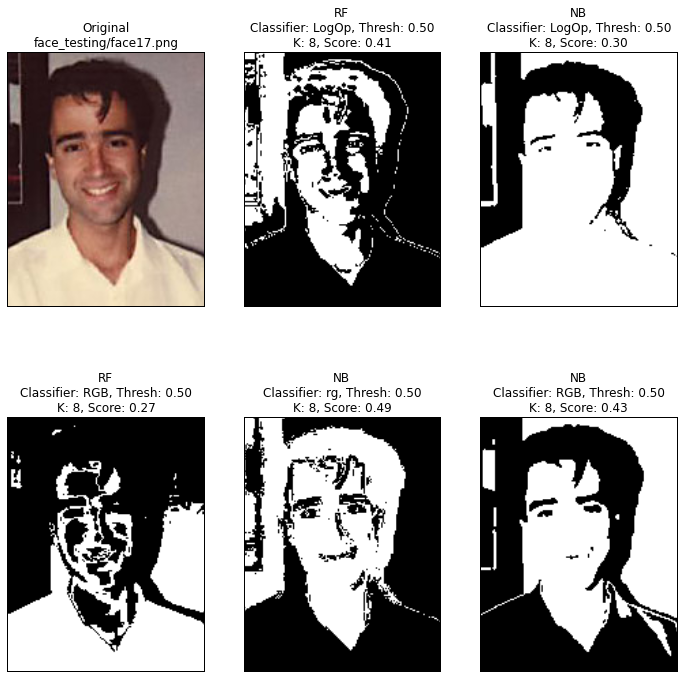

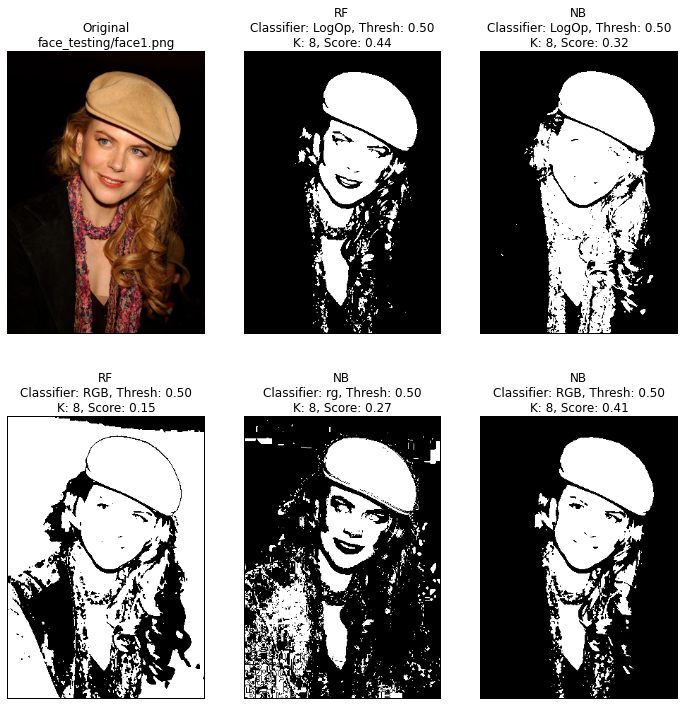

In [10]:
def paramterator():
    # Iterate over a range of features x overlap thresh x n_clusters to
    # find the best combo for each test image
    params = {}
    for train in [False]:
        for thresh in [0.5]:
            for n_cluster in [8]:
                for clf in ["NB", "RF"]:
                    for feature in ["RGB", "rg", "LogOp"]:
                        params["classifier"] = clf
                        params["feature"] = feature
                        params["thresh"] = thresh
                        params["n_cluster"] = n_cluster
                        params["name"] = "._" + clf + "_" + feature + ".pkl"
                        main(params, train)
                        if not train: # only one iteration for test
                            return

if __name__ == '__main__':
    paramterator()

## Discussion on Results and Limitations 

My results were not what I had hoped for. I had initially planned on sweeping over various values of overlap thresholds and clusters, but spent much of my last day trying to debug a disconnect between the program that performed the parameter sweep (which took a long time) and the program which ran the tests based on the best set of parameters. 

In the end, I refactored the code and iterated over a much smaller parameter space. Some of the images, for example, 24, Denzel, would do much better with fewer clusters than 8.

The minimal "best" test result was face 19 with a score of 0.28 and the maximum  "best" test result was 0.88 for for Professor Sun. 

The table below provides a short summary of performance for the various parameter combinations. Naive Bayes normalized r, g performed the best overall with Random Forest Log-Opponent a close second. It is not surprising that one algorithm performs well with certain image characteristics while the other has its own. 


| Parameter Space     | Max Count |     
| ------------------- | --------- |
| Random Forest RGB   | 2         |
| Random Forest LogOp | 6         |
| Naive Bayes RGB     | 4         |
| Naive Bayes rg      | 7         |
| Naive Bayes LogOp   | 1         |


One of the main limitations was K-means clustering. In the first place, it is by far the most computationally intensive operation and constrains the amount of time needed to try and test new code. Secondly, it is sensitive to the initial seed and can lead to inconsistent results. To minimize these effects, I made the convergence tolerance small and had the algorithm try > 50 seeds per clustering.  

# Python Code Listings

### Hw2_functions.py
##### Non-algorithmic Utility Functions for SkinFinding.py

In [1]:
import numpy as np
import pickle
import argparse
import re
from glob import glob
from os.path import join, split


def get_args():
    '''This function parses and return arguments passed in'''
    # Assign description to the help doc
    parser = argparse.ArgumentParser(
        description='Control execution of Hw2.py')
    # Add arguments
    parser.add_argument(
        '-d', '--debug', type=bool, help='Debug or not',
        default=False, required=False)
    parser.add_argument(
        '-s', '--samples', type=bool, help='Load Samples or not',
        default=False, required=False)
    parser.add_argument(
        '-c', '--clsfr', type=bool, help='Load Classifier or not',
        default=False, required=False)
    args = parser.parse_args()

    return args.debug, args.samples, args.clsfr


def cache_results(score, params):
    R = {}
    R["Overlap_Thresh"] = params["thresh"]
    R["Kmeans"] = params["n_cluster"]
    R["Feature"] = params["feature"]
    R["Score"] = score
    R["Mean"] = np.mean(score)
    Results = pickle.load(open(".Results_Cache", 'r'))
    Results.append(R)
    pickle.dump(Results, open(".Results_Cache", 'w'))
    return Results


def print_(verbose, msg):
    if verbose:
        print(msg)


def get_groundname(name):
    im_num = int(re.findall('\d+', name)[0])
    ground = re.findall('train|test', name)[0]
    groundname = glob(join("face_%sing_groundtruth" % (ground),
                           "*mask%d.png" % im_num))[0]
    return groundname

### SkinFinding.py
##### Main Skin Finding program

#### get_norm_rg(im) --> Given an image, return RGB and normalized rg feature vectors

In [2]:
def get_norm_rg(im):
    # Apply filtering
    im = median_filter(im, 2)
    # ipdb.set_trace()
    # image, int --> array, float
    rgb = im.reshape((-1, 3)).astype('float32')
    # sum along columns
    rgbsum = np.sum(rgb, axis=1)
    # prepare for array d3ivision
    rgbsum = np.tile(rgbsum, (3, 1)).transpose()
    # avoid div by 0
    rgbsum[np.where(rgbsum == 0)] = 1
    # normalize rgb array
    rgbnorm = np.divide(rgb, rgbsum)
    # create feature vector
    return np.hstack([rgb, rgbnorm[:, :2]])

#### get_log_opponent(im) --> Given an image, return Log Opponent feature vectors 

In [3]:
def get_log_opponent(im):
    # from forsyth, skin_finding
    im[im == 0] = 0.01  # avoid NaN
    # The input R G B values are transformed into a log opponent representation
    i = np.log(im[:, :, 1])
    rg = np.log(im[:, :, 0]) - i
    by = np.log(im[:, :, 2]) - (i + rg) / 2

    # "The Rg and By arrays are smoothed with a median filter"
    rg = median_filter(rg, 2)
    by = median_filter(by, 2)
    i = median_filter(i, 2)
    intensity = im
    intensity[:, :, 0] = np.abs(im[:, :, 0] - i)
    intensity[:, :, 1] = np.abs(im[:, :, 1] - i)
    intensity[:, :, 2] = np.abs(im[:, :, 2] - i)
    im = np.zeros((im.shape[0], im.shape[1], 5))
    im[:, :, :3] = intensity
    im[:, :, 3] = rg
    im[:, :, 4] = by
    return im.reshape((-1, 5))

#### get_truth_overlap(kmeans, im_rgb, mask, thresh=0) --> Given training parameters, return a dict containing Labels, Cluster Centers, % Overlap of image  

In [4]:
def get_truth_overlap(kmeans, im_rgb, mask, thresh=0):
    labels = np.unique(mask)
    # D is the output list of dicts
    D = [{} for l in labels]
    # Count occurences of each label in mask
    mask_counts = [np.count_nonzero(mask == lb) for lb in labels]
    total_counts = [np.count_nonzero(im_rgb == lb) for lb in labels]
    for i, mask_count in enumerate(mask_counts):
        if total_counts[i] == 0:
            overlap = 0
        else:
            overlap = mask_count / float(total_counts[i])
        D[i]["Center"] = kmeans.cluster_centers_[labels[i], :]
        D[i]["Class"] = (overlap > thresh)*255
    return D

#### im2feature(im_name, params) --> A wrapper to parse params and return feature vectors

In [5]:
def im2feature(im_name, params):
    im_train = imread(im_name)
    (w, h, d) = im_train.shape

    print_(verbosity, "\tExtracting feature vectors... ")
    if params["feature"] == "RGBrg":
        fvec_ = get_norm_rg(im_train)
    elif params["feature"] == "LogOp":
        fvec_ = get_log_opponent(im_train)
    elif params["feature"] == "RGB":
        fvec_ = get_norm_rg(im_train)[:, :3]
    elif params["feature"] == "rg":
        fvec_ = get_norm_rg(im_train)[:, 3:]
    elif params["feature"] == "BothRGBLOG":
        fvec_ = get_norm_rg(im_train)
        fvec_ = np.hstack([fvec_, get_log_opponent(im_train)])

    print_(verbosity, "\tClassifying features ...")
    kmeans = KMeans(n_clusters=params["n_cluster"], tol=.001, n_jobs=4,
                    max_iter=300, n_init=52, verbose=0).fit(fvec_)
    labels = kmeans.predict(fvec_)
    fvec = np.zeros(fvec_.shape)

    for i, lab in enumerate(labels):
        fvec[i, :] = kmeans.cluster_centers_[lab, :]
    labels = labels.reshape((w, h)).astype(np.uint8)

    return labels, kmeans, fvec

#### get_training_samples(trainset, params) --> Iterate over a set of training images and return Samples and Labels for the Classifier

In [6]:
def get_training_samples(trainset, params):
    Samples = np.zeros((200, len(params["feature"])))
    Labels = np.ones(200,)
    k = 0
    for i, trainname in enumerate(trainset):
        print_(verbosity, "\tBeginning training and truth image set %d of %d... "
               % (i+1, len(trainset)))
        truthname = get_groundname(trainname)
        im_truth = imread(truthname)[:, :, 0].astype(np.uint8)
        rgb_lab, kmeans, fvec = im2feature(trainname, params)
        mask = rgb_lab * im_truth
        overlap = get_truth_overlap(kmeans, rgb_lab, mask,
                                    thresh=params["thresh"])
        print_(verbosity, "\tCache Samples/Labels ...\n")
        for lap in overlap:
            Samples[k, :] = lap["Center"]
            Labels[k] = lap["Class"]
            k += 1

    # Remove Missing Labels
    keepers = Labels != 1
    return Labels[keepers], Samples[keepers, :]

#### paramterator() --> A wrapper to Iterate over a range of classifiers x features x overlap thresh x n_clusters to cache the results for each test image

#### Import and Globals for SkinFinding.py

In [7]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-
__author__ = "Paul Adams"
__assignment__ = "Homework 2"
__course__ = "EE596"
import pprint
%matplotlib inline
# import matplotlib
# matplotlib.use("Qt4Agg")
# import matplotlib.pyplot as plt
from matplotlib.pyplot import imread
from glob import glob
import pickle
from os.path import join
import numpy as np
from sklearn.cluster import KMeans
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import jaccard_similarity_score
from skimage.filters import gaussian_filter
from skimage.color import rgb2gray
from scipy.ndimage.filters import median_filter
from time import time
import sys
import ipdb
sys.path.append('/home/adamspr/ee596/MachineVision')
from ScreenImage import ScreenImage
from HW2_functions import cache_results, print_, get_groundname
verbosity = False

In [8]:
def main(params, train):
    si = ScreenImage()
    if train:
        # Initialization
        trainset = glob(join("face_training", "face*.png"))
        t0 = time()

        print_(verbosity, "Begin collecting training Samples")
        Labels, Samples = get_training_samples(trainset, params)
        print_(verbosity, "Success. Elapsed: %.2f s." % (time() - t0))

        print_(verbosity, "Begin classifier training using %s..."
               % (params["classifier"]))
        if params["classifier"] == "NB":
            clf = GaussianNB()
        elif params["classifier"] == "RF":
            clf = RandomForestClassifier()
        clf.fit(Samples, Labels)
        pickle.dump([clf, params], open(params["name"], "w"))
    else:
        testset = glob(join("face_testing", "face*.png"))
        print_(verbosity, "Begin classifier prediction...")
        score = np.zeros(len(testset),)
        models = glob("._*")

        for i, testname in enumerate(testset):
            im_orig = imread(testname)
            truthname = get_groundname(testname)
            im_skin = [[] for k in models]
            title = ["" for k in models]
            for j, model in enumerate(models):
                im_truth = rgb2gray(imread(truthname)).astype(np.uint8)*255
                pkl = pickle.load(open(model, "r"))
                clf = pkl[0]
                params = pkl[1]
                _, _, fvec = im2feature(testname, params)
                im_skin[j] = clf.predict(fvec).reshape(im_truth.shape).astype(np.uint8)
                score = jaccard_similarity_score(im_truth, im_skin[j], normalize=True)
                title[j] = "%s\nClassifier: %s, Thresh: %.2f\nK: %d, Score: %.2f" \
                    % (params["classifier"], params["feature"], params["thresh"],
                       params["n_cluster"], score)
                print_(verbosity, "\tTest %d of %d, Score %.2f\n" % (i+1, len(testset), score))

            si.show(testname, [im_orig, im_skin[0], im_skin[1],
                               im_skin[2], im_skin[3], im_skin[4]],
                    ["Original\n%s" % testname, title[0], title[1],
                    title[2], title[3], title[4]])